In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ashar\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\pyth

In [2]:
import tensorflow as tf

tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None)

True

## Configurations

In [3]:
class AerialConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "aerial"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + buildings + pool

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 268

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = AerialConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Dataset

In [4]:
class AerialDataset(utils.Dataset):

    def load_aerial(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("structure", 1, "building")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
                categories = [b['building'] for b in [r['region_attributes'] for r in a['regions'].values() ]]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                categories = [b['building'] for b in [r['region_attributes'] for r in a['regions'] ]]
                
            
            print(categories)
            print("#####################################")
            category_ids = []
            
            for category in categories:
                if category == "true":
                    category_ids.append(1)
                elif category == "pool":
                    category_ids.append(2)
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "structure",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                category_ids=category_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "structure":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        
        category_ids = np.array(info["category_ids"], dtype=np.int32)
        
        return mask.astype(np.bool),category_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "structure":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)




In [5]:
import json
dataset = ROOT_DIR + "\\datasets\\buildings"

# Training dataset.
dataset_train = AerialDataset()
dataset_train.load_aerial(dataset, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = AerialDataset()
dataset_val.load_aerial(dataset, "val")
dataset_val.prepare()



['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true']
#####################################
['true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['tr

['true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true']
#####################################
['true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true', 'true']
#####################################
['true', 'true', 'true']
#####################################
['true', 'true', 'true', 'true', 'true', 'true']
##########

## Visualize Random Samples

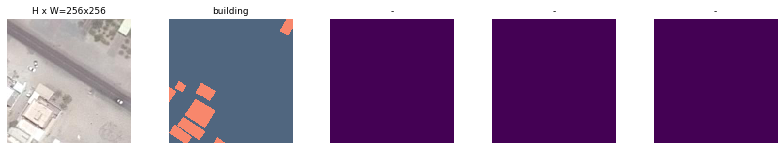

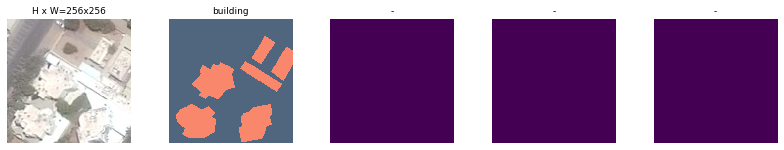

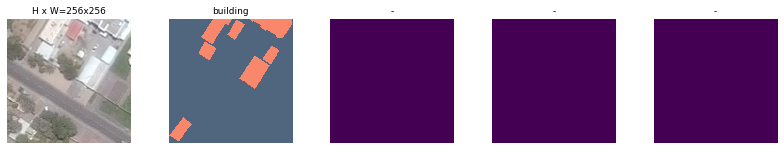

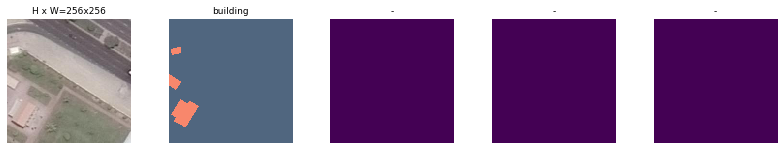

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [1]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

NameError: name 'modellib' is not defined

In [67]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')

NameError: name 'model' is not defined

## Detection

In [7]:
class InferenceConfig(AerialConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.9

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "mask_rcnn_aerial_0036.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  mask_rcnn_aerial_0036.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:  112.00000  max:  875.00000  int32
gt_mask                  shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000  bool


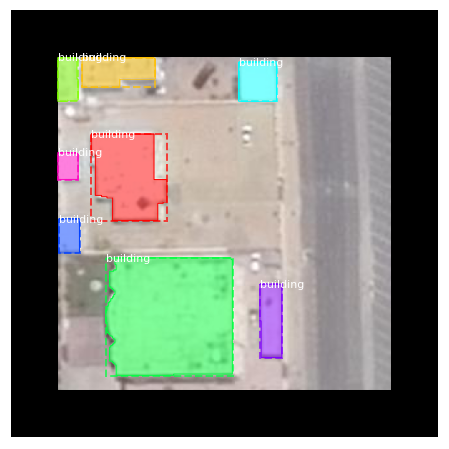

In [8]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



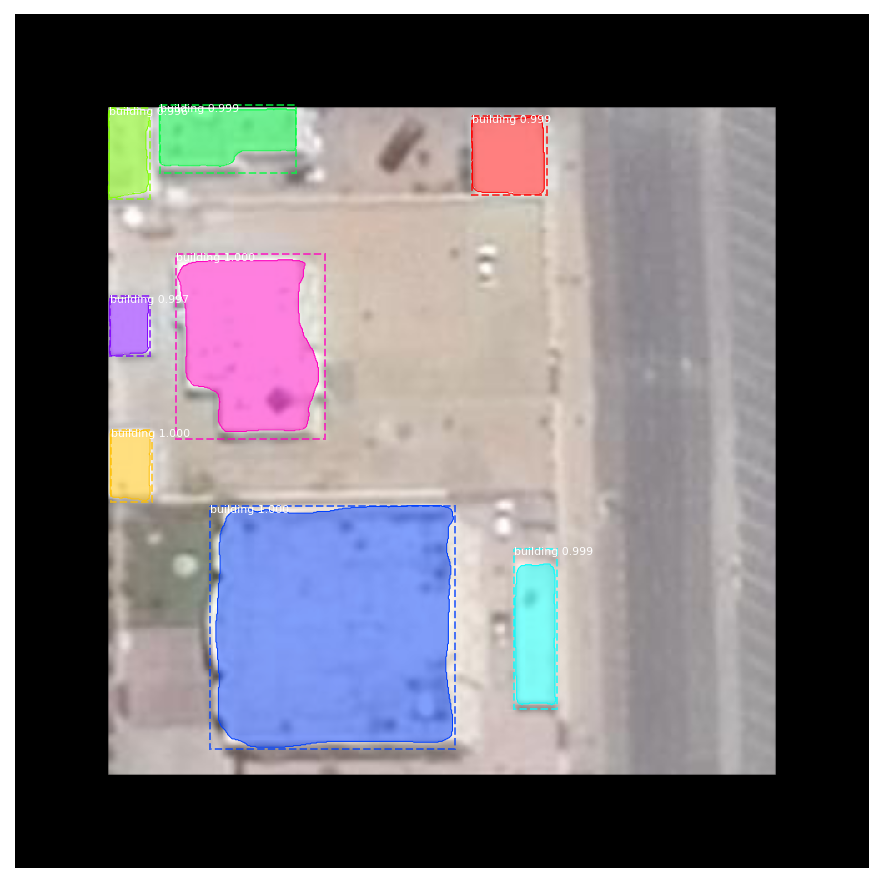

In [9]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


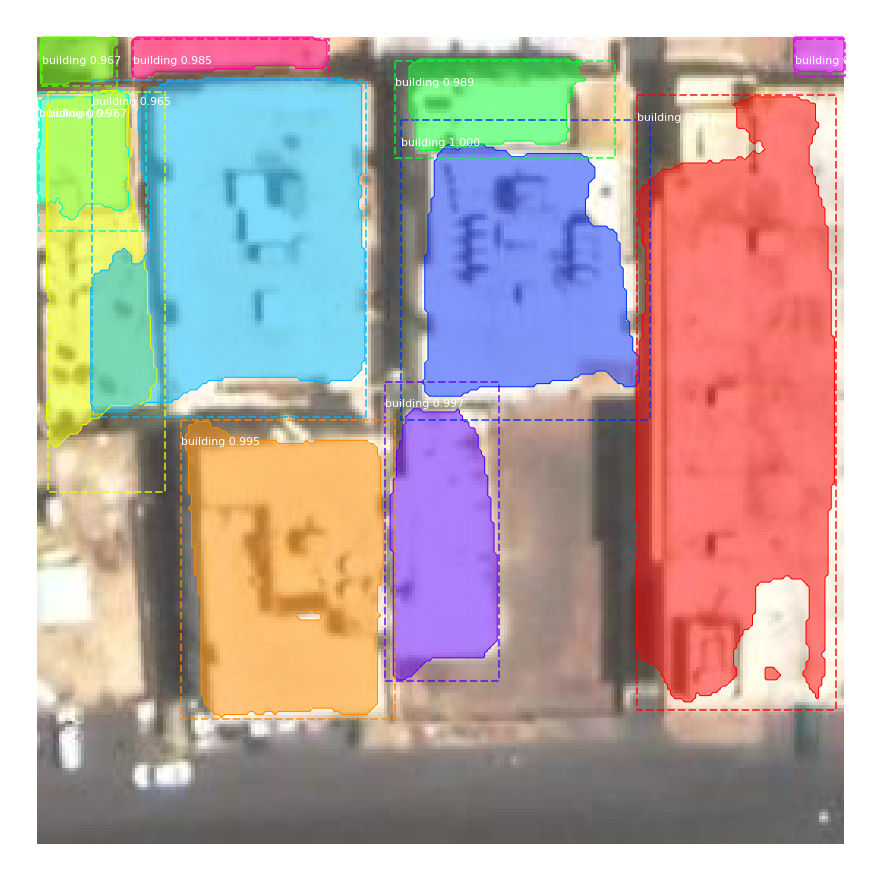

[1 1 1 1 1 1 1 1 1 1 1]


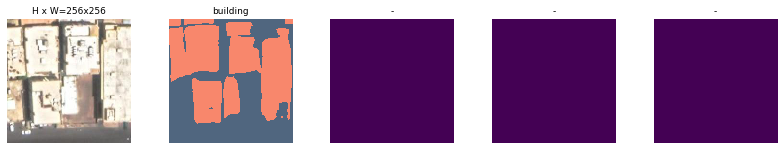

In [10]:
image_file = "230247.jpg"
image = skimage.io.imread(image_file)
r = model.detect([image], verbose=1)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])
print(r['class_ids'])
visualize.display_top_masks(image, r['masks'], r['class_ids'], 
                            dataset_val.class_names)

In [49]:
import cv2
import numpy as np
from PIL import Image
import mercantile
import collections
import geojson
import shapely.geometry
import math


def pixel_to_location(dx, dy):
    """Converts a pixel in a tile to a coordinate.
    Args:
      tile: the mercantile tile to calculate the location in.
      dx: the relative x offset in range [0, 1].
      dy: the relative y offset in range [0, 1].
    Returns:
      The coordinate for the pixel in the tile.
    """

    assert 0 <= dx <= 1, "x offset is in [0, 1]"
    assert 0 <= dy <= 1, "y offset is in [0, 1]"

    west, south, east, north = mercantile.bounds(320100,230247,19)

    def lerp(a, b, c):
        return a + c * (b - a)

    lon = lerp(west, east, dx)
    lat = lerp(south, north, dy)

    return lon, lat


def denoise(mask, eps):
    """Removes noise from a mask.
    Args:
      mask: the mask to remove noise from.
      eps: the morphological operation's kernel size for noise removal, in pixel.
    Returns:
      The mask after applying denoising.
    """

    struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (eps, eps))
    #return cv2.morphologyEx(mask, cv2.MORPH_OPEN, struct)
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(mask,kernel,iterations = 2)

def grow(mask, eps):
    """Grows a mask to fill in small holes, e.g. to establish connectivity.
    Args:
      mask: the mask to grow.
      eps: the morphological operation's kernel size for growing, in pixel.
    Returns:
      The mask after filling in small holes.
    """

    struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (eps, eps))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, struct)

def contours(mask):
    """Extracts contours and the relationship between them from a binary mask.
    Args:
      mask: the binary mask to find contours in.
    Returns:
      The detected contours as a list of points and the contour hierarchy.
    Note: the hierarchy can be used to re-construct polygons with holes as one entity.
    """

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

def simplify(polygon, eps):
    """Simplifies a polygon to minimize the polygon's vertices.
    Args:
      polygon: the polygon made up of a list of vertices.
      eps: the approximation accuracy as max. percentage of the arc length, in [0, 1]
    """

    assert 0 <= eps <= 1, "approximation accuracy is percentage in [0, 1]"

    epsilon = eps * cv2.arcLength(polygon, closed=True)
    return cv2.approxPolyDP(polygon, epsilon=epsilon, closed=True)


def parents_in_hierarchy(node, tree):
    """Walks a hierarchy tree upwards from a starting node collecting all nodes on the way.
    Args:
      node: the index for the starting node in the hierarchy.
      tree: the hierarchy tree containing tuples of (next, prev, first child, parent) ids.
    Yields:
      The node ids on the upwards path in the hierarchy tree.
    """

    def parent(n):
        # next, prev, fst child, parent
        return n[3]

    at = tree[node]
    up = parent(at)

    while up != -1:
        index = up
        at = tree[index]
        up = parent(at)

        assert index != node, "upward path does not include starting node"

        yield index
        
def featurize(polygon, shape):
    """Transforms polygons in image pixel coordinates into world coordinates.
    Args:
      tile: the tile this polygon is in for coordinate calculation.
      polygon: the polygon to transform from pixel to world coordinates.
      shape: the image's max x and y coordinates.
    Returns:
      The closed polygon transformed into world coordinates.
    """

    xmax, ymax = shape

    feature = []

    for point in polygon:
        px, py = point[0]
        dx, dy = px / xmax, py / ymax

        feature.append(pixel_to_location(dx, 1. - dy))

    assert feature, "at least one location in polygon"
    feature.append(feature[0])  # polygons are closed

    return feature

def meters_per_pixel(size):
    """Returns the resolution for a tile.
    Args:
      tile: the mercantile.tile to calculate the resolution for.
      size: the size in pixels for this tile (e.g. 256).
    Returns:
      The resolution in meters per pixel.
    """

    # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Resolution_and_Scale

    z = 19
    lat = mercantile.ul(320100,230247,19).lat

    radius = 6378137
    mpp = radius * 2 * math.pi / size
    resolution = mpp * math.cos(math.radians(lat)) / (2 ** z)

    return resolution


{"features": [{"geometry": {"coordinates": [[[39.795367, 21.38691], [39.79538, 21.386712], [39.795388, 21.386705], [39.795495, 21.386705], [39.795503, 21.386712], [39.795509, 21.38682], [39.795503, 21.386895], [39.795391, 21.3869], [39.795367, 21.38691]], [[39.795434, 21.386782], [39.795436, 21.386785], [39.795444, 21.386785], [39.795447, 21.386787], [39.795471, 21.386787], [39.795479, 21.386782], [39.795479, 21.38676], [39.795476, 21.386757], [39.795439, 21.386757], [39.795434, 21.386762], [39.795434, 21.386782]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [[[39.795573, 21.386922], [39.795552, 21.38692], [39.795544, 21.386892], [39.795541, 21.386742], [39.795552, 21.38675], [39.795595, 21.38675], [39.795605, 21.386762], [39.795595, 21.386887], [39.795586, 21.38691], [39.795573, 21.386922]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [[[39.795581, 21.387129], [39.795568, 21.387047], [39.795568, 21

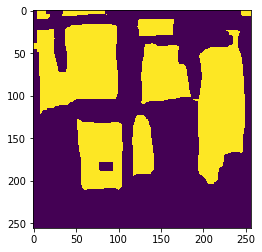

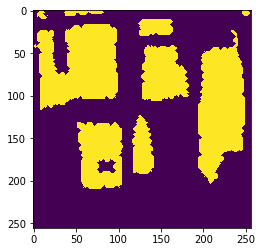

In [53]:
kernel_size_denoise_m = 100
kernel_size_grow_m = 10
simplify_threshold = 0.01

image = np.array(Image.open("out1.png").convert("P"), dtype=np.uint8)
mask = (image == 0).astype(np.uint8)

resolution = meters_per_pixel(mask.shape[0])
kernel_size_denoise_px = round(kernel_size_denoise_m / resolution)
kernel_size_grow_px = round(kernel_size_grow_m / resolution)
       

denoised = denoise(mask, kernel_size_denoise)
grown = grow(denoised, kernel_size_grow)

plt.imshow(denoised, interpolation='none')



multipolygons, hierarchy = contours(denoised)

for polygon in multipolygons:
    cv2.drawContours(denoised, polygon, -1, (0, 255, 0), 3)
    
plt.figure()
plt.imshow(denoised)

if hierarchy is None:
    print("none")

# In the following we re-construct the hierarchy walking from polygons up to the top-most polygon.
# We then crete a GeoJSON polygon with a single outer ring and potentially multiple inner rings.
#
# Note: we currently do not handle multipolygons which are nested even deeper.

# This seems to be a bug in the OpenCV Python bindings; the C++ interface
# returns a vector<vec4> but here it's always wrapped in an extra list.
assert len(hierarchy) == 1, "always single hierarchy for all polygons in multipolygon"
hierarchy = hierarchy[0]

assert len(multipolygons) == len(hierarchy), "polygons and hierarchy in sync"

polygons = [simplify(polygon, simplify_threshold) for polygon in multipolygons]

# Todo: generalize and move to features.core

# All child ids in hierarchy tree, keyed by root id.
features = collections.defaultdict(set)

for i, (polygon, node) in enumerate(zip(polygons, hierarchy)):
    if len(polygon) < 3:
        print("Warning: simplified feature no longer valid polygon, skipping", file=sys.stderr)
        continue

    _, _, _, parent_idx = node

    ancestors = list(parents_in_hierarchy(i, hierarchy))

    # Only handles polygons with a nesting of two levels for now => no multipolygons.
    if len(ancestors) > 1:
        print("Warning: polygon ring nesting level too deep, skipping", file=sys.stderr)
        continue

    # A single mapping: i => {i} implies single free-standing polygon, no inner rings.
    # Otherwise: i => {i, j, k, l} implies: outer ring i, inner rings j, k, l.
    root = ancestors[-1] if ancestors else i

    features[root].add(i)
    
geojson_features = []

for outer, inner in features.items():
    rings = [featurize(polygons[outer], mask.shape[:2])]

    # In mapping i => {i, ..} i is not a child.
    children = inner.difference(set([outer]))

    for child in children:
        rings.append(featurize(polygons[child], mask.shape[:2]))

    assert 0 < len(rings), "at least one outer ring in a polygon"

    geometry = geojson.Polygon(rings)
    shape = shapely.geometry.shape(geometry)

    if shape.is_valid:
        geojson_features.append(geojson.Feature(geometry=geometry))
    else:
        print("Warning: extracted feature is not valid, skipping", file=sys.stderr)

collection = geojson.FeatureCollection(geojson_features)

print(collection)

with open("out.geojson", "w+") as fp:
    geojson.dump(collection, fp)